# Прогнозирование оттока клиентов в фитнес-центрах

## Описание проекта   

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.        
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.  

А именно:          
-научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;          
-сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;           
-проанализировать основные признаки, наиболее сильно влияющие на отток;       
-сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:       
1) выделить целевые группы клиентов;      
2) предложить меры по снижению оттока;        
3) определить другие особенности взаимодействия с клиентами.     



«Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:         

**Данные клиента за предыдущий до проверки факта оттока месяц:**   

* 'gender' — пол;   

* 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;     

* 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);      

* Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);      

* 'Phone' — наличие контактного телефона;   

* 'Age' — возраст;       

* 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).   

**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:**

* 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);      

* 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);      

* 'Group_visits' — факт посещения групповых занятий;       

* 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;  

* 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;     

* 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.       

* 'Churn' — факт оттока в текущем месяце.





## Загрузка данных

In [1]:
# импортируем библиотеки

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [3]:
# изучим файл с данными
df = pd.read_csv("/datasets/gym_churn.csv")
df.head(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [5]:
# Приведем название столбов к нижнему регистру
df.columns = [x.lower().replace(" ", "_") for x in df.columns.values]

In [6]:
# проверим датафрейм на дубликаты
df.duplicated().sum()

0

**Выводы**   
* В датафрейме 14 столбцов и 4000 строк.     
* Пропусков и дубликатов нет.      
* Название столбцов привели к нижнему регистру

##  Исследовательский анализ данных (EDA)

### Посмотрите на датасет: есть ли в нем отсутствующие признаки, изучите средние значения и стандартные отклонения     

In [7]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


* Мужчин и женщин ходит примерно одинаковое количество mean=0.51       
* Большинство клиентов проживают близко к фитнес центру mean=0.86  
* По партнерской программе пришло почти половина клиентов  mean=0.49   
* Треть клиентов пришла по акции Приведи друга  mean=0.31   
* Телефон указан практически у всех клиетов  mean=0.9, std=0.3   
* Длительность абонемента имеют большой разброс,судя по стандаотному отклонению mean=4.68, std=4.59      
* Чуть меньше половины клиентов посещвют групповые занятия mean=0.41, std=0.49    
* Средний возраст клиента 29 лет, минимальный 18 лет,максимальный-41 год    
* Выручка от дополнительный услуг фитнес клуба в среднем 147 тыс, max= 552 тыс    
* Срок до окончания абонемента имеет большой разброс mean=4.32, std=4.19    
* Лайфтайм имеет большой разброс mean=3.72, std=3.75   
* Средняя частота посещений 1-2 раза в неделю, max= 6   
* Средний Отток 26.5 % с std=0.44


### Посмотрите на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался 

In [8]:
df.groupby("churn").agg("mean").T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


* **В отток чаще уходят клиенты у которых абонемент на короткий срок, занимаются около месяца и дальше живут от клуба. Клиенты с парнерской программы и пришедшие по акции остаются чаще**

### Постройте столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

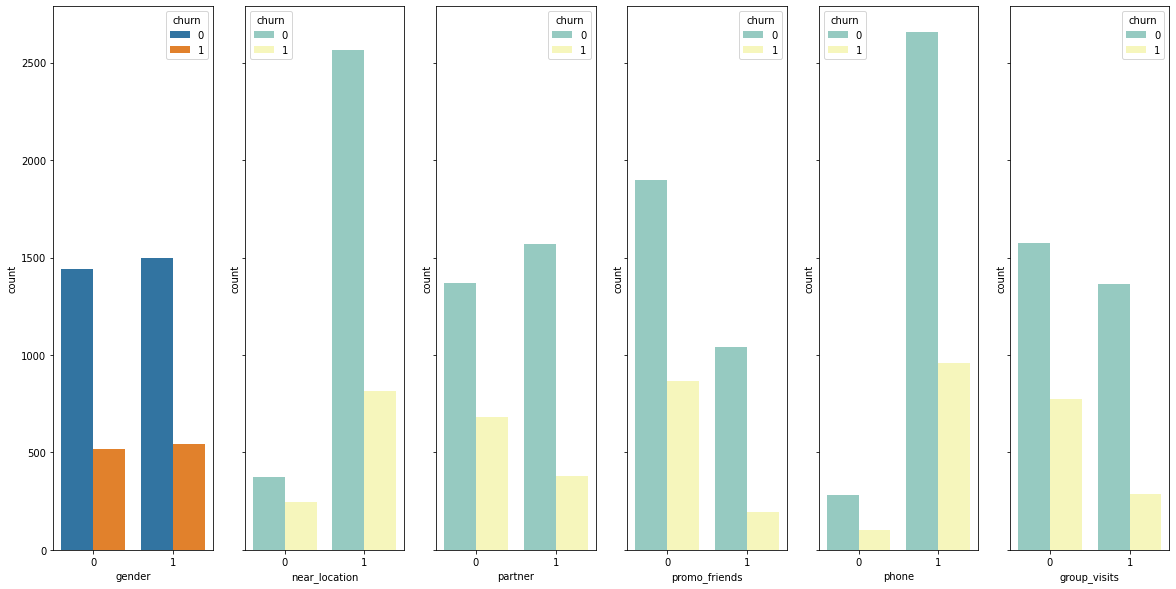

In [10]:
# построим графики для бинарных признаков
n_rows = 1
n_cols = 6

fig, axes = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    sharex=True,
    sharey=True,
    constrained_layout=False,
    figsize=(20, 10),
)
i = 0
cols = ["gender", "near_location", "partner", "promo_friends", "phone", "group_visits"]
for idx, x in enumerate(cols):
    column = cols[idx]
    sns.countplot(x=df[column], hue="churn", data=df, ax=axes[idx])
    sns.set_palette("Set3")

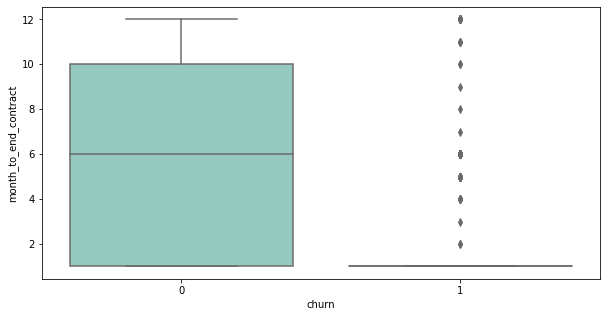

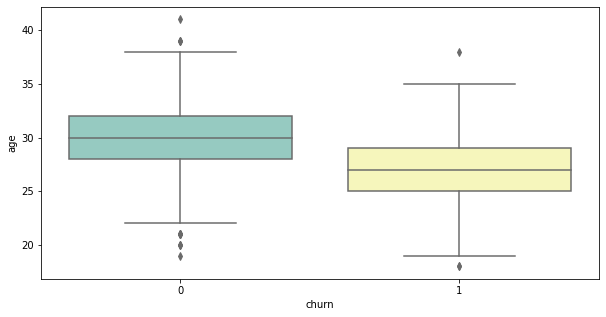

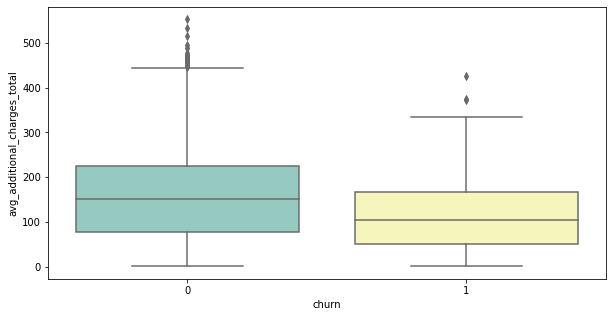

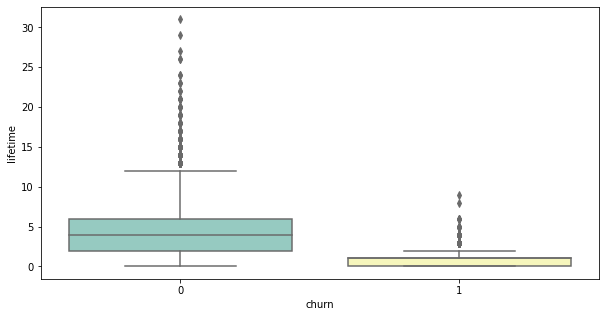

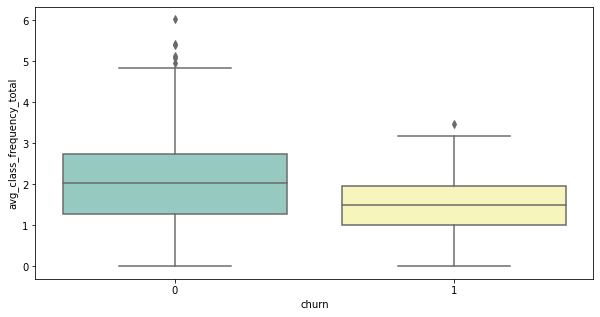

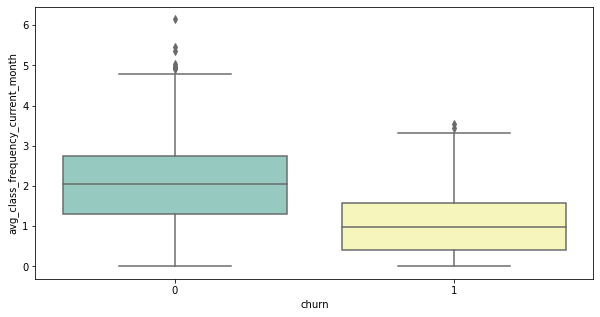

In [11]:
# построим графики для небинарных признаков
for column in [
    "month_to_end_contract",
    "age",
    "avg_additional_charges_total",
    "lifetime",
    "avg_class_frequency_total",
    "avg_class_frequency_current_month",
]:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x="churn", y=df[column], data=df)
    plt.show()

### Постройте матрицу корреляций и отобразите её

In [12]:
# построим и отрисуем матрицу корреляций
cm = df.corr()
cm

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
near_location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


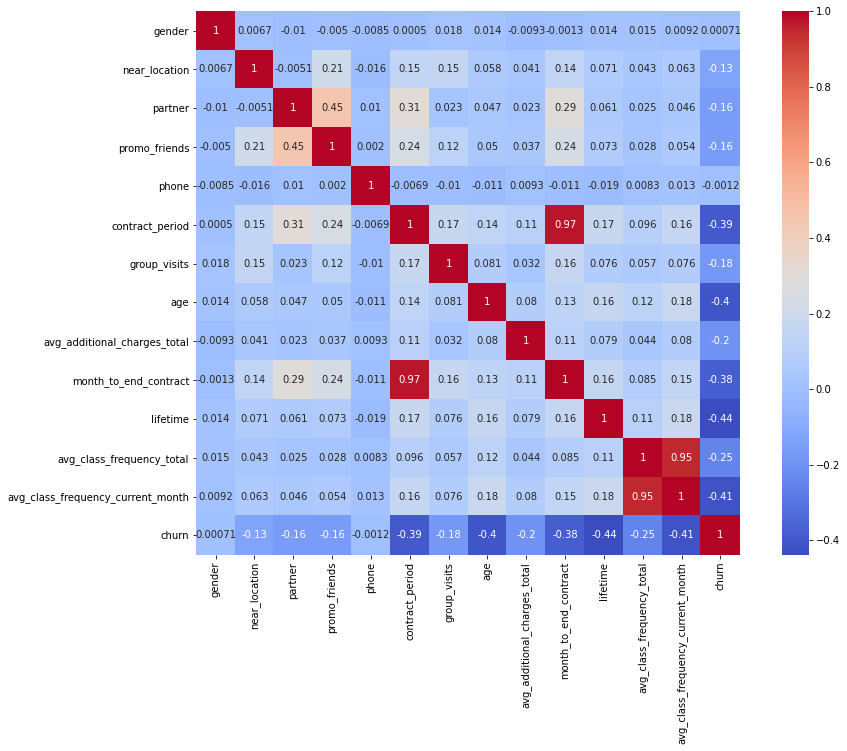

In [13]:
# нарисуем тепловую карту с подписями для матрицы корреляций
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, square=True, cmap="coolwarm")
plt.show()

* Наиболее сильно коррелируют признаки Средняя частота посещений в неделю за все время с начала действия абонемента(Avg_class_frequency_total) со Средней частотой посещений в неделю за предыдущий месяц(Avg_class_frequency_current_month) и длительность текущего действующего абонемента(Contract_period) со сроком до окончания текущего действующего абонемента(Month_to_end_contract). Коэффиуиенты корреляции равны 0.95 и 0.97 соответственно.Эти признаки мультиколлинеарны     
* Признаки с практически нулевой корреляцией-пол и номер телефона
* На отток клиентов больше всего влияет лайфтайм,средняя частота посещений ,возраст и период контракта.

### Выводы исследовательского анализа данных

* На отток клиентов больше всего влияет лайфтайм,средняя частота посещений ,возраст и период контракт         
* В отток чаще уходят клиенты у которых абонемент на короткий срок, занимаются около месяца и дальше живут от клуба. Клиенты с парнерской программы и пришедшие по акции остаются чаще          
* Наиболее сильно коррелируют признаки Средняя частота посещений в неделю за все время с начала действия абонемента(Avg_class_frequency_total) со Средней частотой посещений в неделю за предыдущий месяц(Avg_class_frequency_current_month) и длительность текущего действующего абонемента(Contract_period) со сроком до окончания текущего действующего абонемента(Month_to_end_contract). Коэффициенты корреляции равны 0.95 и 0.97 соответственно.Эти признаки мультиколлинеарны   
* Признаки с практически нулевой корреляцией-пол и номер телефона

## Модель прогнозирования оттока клиентов

In [14]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y) и удалим по одному признаку из пары мультиколлинеарных
X = df.drop(
    columns=["churn", "avg_class_frequency_current_month", "month_to_end_contract"]
)
y = df["churn"]

In [15]:
# разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

#### Логистическая регрессия

In [16]:
# задаем  алгоритм для нашей модели
model = LogisticRegression(solver="liblinear")

In [17]:
# обучим модель на обучающей выборке
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [18]:
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:, 1]

In [19]:
# выведем метрики
print("Accuracy: {:.2f}".format(accuracy_score(y_test, predictions)))
print("Precision: {:.2f}".format(precision_score(y_test, predictions)))
print("Recall: {:.2f}".format(recall_score(y_test, predictions)))

Accuracy: 0.90
Precision: 0.83
Recall: 0.80


* Метрика Accuracy-доля правильно угаданных ответов равна 90%  
* Метрика Precision-доля прозноза относительно оттока клиентов 0.83            
* Метрика Recall показывает сколько реальных клиентов,находящихся в оттоке удалось обнаружить 0.80

In [20]:
# создадим датафрейм с именами признаков и их важностью и выведем его по убыванию важности
pd.DataFrame(
    columns=["coeff"], data=abs(model.coef_[0].round(3)), index=X_test.columns
).sort_values(by="coeff", ascending=False)

,coeff
lifetime,0.912
group_visits,0.629
avg_class_frequency_total,0.590
promo_friends,0.353
contract_period,0.277
age,0.213
gender,0.110
phone,0.076
partner,0.031
near_location,0.028


* Наиболее важными признаками влияющими на отток оказались lifetime-время с момента первого обращения,групповые посещения и средняя частота посещений в неделю.  
* Наименее важные признаки суммарная выручка от доп услуг, расстояние от дома и партнерская программа

#### Случайный лес

In [21]:
# найдем оптимальные параметры
score = 0
n_estimators = 1

for i in range(1, 100):
    m = RandomForestClassifier(n_estimators=i, random_state=0)
    m.fit(X_train, y_train)
    predictions = m.predict(X_test)
    score_test = accuracy_score(y_test, predictions)
    if score_test > score:
        score = score_test
        n_estimators = i
print(score)
print(n_estimators)

0.8975
95


In [22]:
model_forest = RandomForestClassifier(n_estimators=95, random_state=0)
model_forest.fit(X_train, y_train)

predictions_forest = model_forest.predict(X_test)
probabilities_forest = model_forest.predict_proba(X_test)[:, 1]

In [23]:
# выведем метрики
print("Accuracy: {:.2f}".format(accuracy_score(y_test, predictions_forest)))
print("Precision: {:.2f}".format(precision_score(y_test, predictions_forest)))
print("Recall: {:.2f}".format(recall_score(y_test, predictions_forest)))

Accuracy: 0.90
Precision: 0.81
Recall: 0.80


* Метрика Accuracy-доля правильно угаданных ответов равна 90%  
* Метрика Precision-доля прозноза относительно оттока клиентов 0.81            
* Метрика Recall показывает сколько реальных клиентов,находящихся в оттоке удалось обнаружить 0.80

In [24]:
# создадим датафрейм с именами признаков и их важностью и выведем его по убыванию важности
pd.DataFrame(
    columns=["coeff"],
    data=abs(model_forest.feature_importances_.round(3)),
    index=X_test.columns,
).sort_values(by="coeff", ascending=False)

,coeff
lifetime,0.334
avg_class_frequency_total,0.171
age,0.153
avg_additional_charges_total,0.132
contract_period,0.117
group_visits,0.021
gender,0.017
partner,0.017
promo_friends,0.015
near_location,0.014


* Наиболее важными признаками влияющими на отток оказались lifetime-время с момента первого обращения,возраст и средняя частота посещений в неделю.  
* Наименее важные признаки телефон, расстояние от дома и акция приведи друга

### Выводы моделей прогнозирования оттоков клиентов

* Для прогнозирования оттоков клиента использовали модели логистической регрессии и случайного леса. Логистическая регрессия показала себя лучше по метрике Precision-доля прозноза относительно оттока клиентов 0.83 против 0.81
Остальные метрики у моделей совпали:  
* Метрика Accuracy-доля правильно угаданных ответов равна 90%              
* Метрика Recall показывает сколько реальных клиентов,находящихся в оттоке удалось обнаружить 0.80    
* Наиболее важными признаками влияющими на отток в обеих моделях оказались lifetime-время с момента первого обращения и средняя частота посещений в неделю.

## Кластеризация клиентов

#### Стандартизируйте данные

In [25]:
sc = StandardScaler()
x_sc = sc.fit_transform(X)

#### Постройте матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуйте дендрограмму.На основании полученного графика предположите, какое количество кластеров можно выделить.

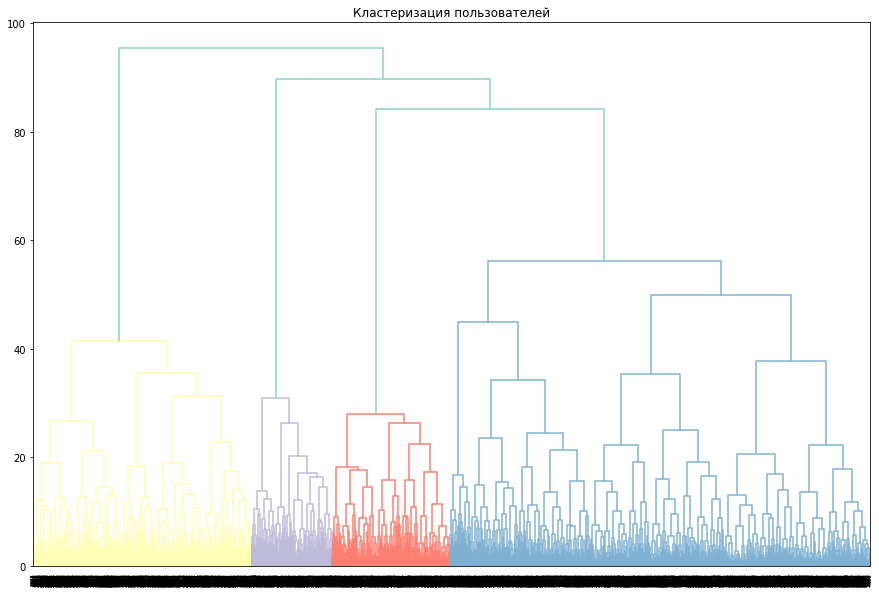

In [26]:
linked = linkage(x_sc, method="ward")
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation="top")
plt.title("Кластеризация пользователей")
plt.show()

#### Обучите модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов.

In [27]:
# по условию задачи примем число кластеров равным 5
km = KMeans(n_clusters=5)
labels = km.fit_predict(x_sc)
df["cluster"] = labels

In [28]:
df.cluster.value_counts()

1    1199
2    1002
3     856
4     557
0     386
Name: cluster, dtype: int64

#### Посмотрите на средние значения признаков для кластеров.

In [30]:
cluster_features = df.groupby("cluster").mean().reset_index()
numeric_columns = cluster_features.drop(columns=["cluster"]).columns
cluster_features.style.format({i: "{:.2f}" for i in numeric_columns}).highlight_max(
    color="yellowgreen", subset=numeric_columns
).highlight_min(color="coral", subset=numeric_columns)

,cluster,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,0,0.52,0.86,0.47,0.31,0.00,4.78,0.43,29.30,144.21,4.47,3.94,1.85,1.72,0.27
1,1,0.51,1.00,0.19,0.05,1.00,1.93,0.31,27.97,124.36,1.87,2.15,1.56,1.35,0.49
2,2,0.50,1.00,0.89,1.00,1.00,6.84,0.52,29.53,152.41,6.26,4.27,1.95,1.90,0.13
3,3,0.53,1.00,0.44,0.01,1.00,7.07,0.54,30.75,179.71,6.42,5.68,2.33,2.32,0.01
4,4,0.50,0.00,0.49,0.08,1.00,2.98,0.23,28.69,137.28,2.80,2.98,1.76,1.60,0.40


* В 0 кластере 944 человека.Обьединены по признакам :near_location=0.99,partner=0.95,promo_friend=0.99.Клиенты из этого кластера пришли по акции Приведи друга,либо сотрудники компании-парнера.Из них 99% живет рядом с клубом.Самая большая Средняя длительность абонемента 7 месяцев из всех кластеров и сумма,потраченная на доп услуги 
avg_additional_charges_total=153 тыс     
* В 1 кластере 561 человек.Обьединены по признаку near_location=0, то есть все живут далеко от клуба      
* В 2 кластере 1235 человек-это самый многочисленный кластер. Все клиенты живут рядом с фитнес-клубом и не посещают групповые занятия    
* В 3 кластере 874 человека.Признак,объединяющий всех клиентов-посещение групповых занятий
* В 4 кластере 386 человек.Клиенты из этой грцппы не указалы свой номер телефона

#### Постройте распределения признаков для кластеров.

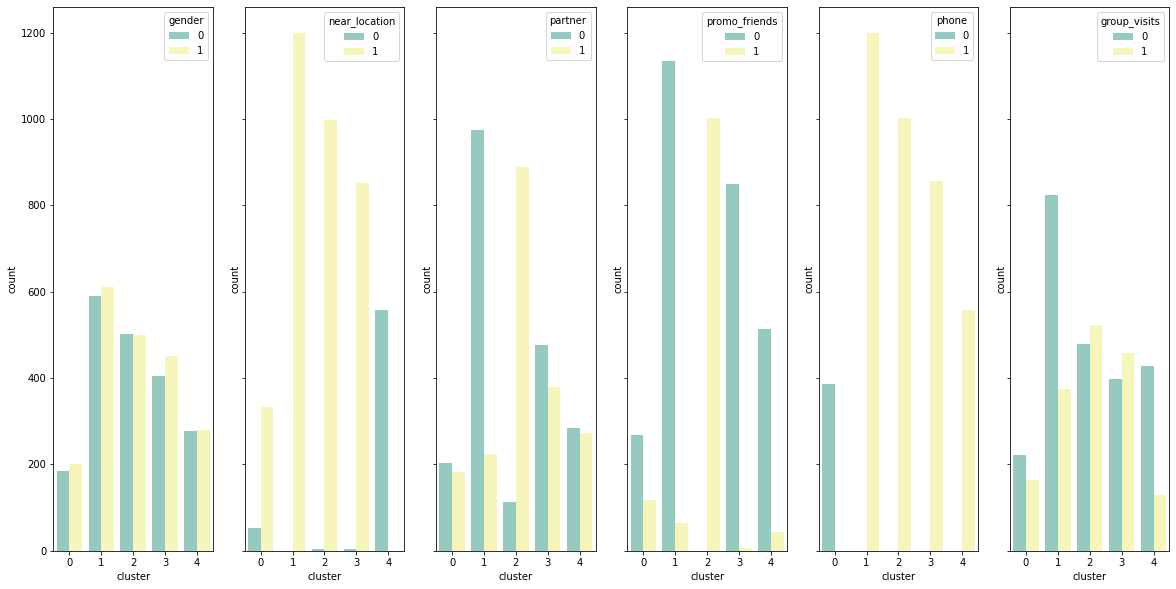

In [32]:
# построим графики для бинарных признаков
n_rows = 1
n_cols = 6

fig, axes = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    sharex=True,
    sharey=True,
    constrained_layout=False,
    figsize=(20, 10),
)
i = 0
cols = ["gender", "near_location", "partner", "promo_friends", "phone", "group_visits"]
for idx, x in enumerate(cols):
    column = cols[idx]
    sns.countplot(x="cluster", hue=df[column], data=df, ax=axes[idx])
    sns.set_palette("Set3")

* Гендерное распределение для кластеров практически одинаковое    
* Расстояние от дома до фитнес центра: ближе всего клиенты из 2,3,4 кластера.Далеко от дома зал у клиентов из 0 кластера   
* Больше всего клиентов,пришедшие по партнерской программе из 0 кластера, а из тех кто ей не пльзовался-2,3 кластер     
* По акции Приведи друга пришли  900 клиентов из 0 кластера, и 1150 человек  не участвующих в этой программе.    
* Около 400 человек из 4 кластера не указали свой номер телефона.    
* Групповые занятия не посещают 1200 человек из 2 кластера ,а  800 человек из 3 кластера наоборот ходят постоянно

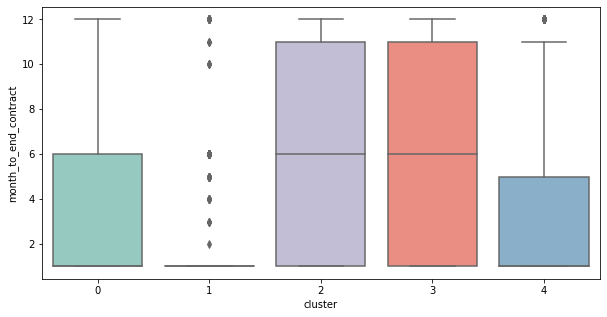

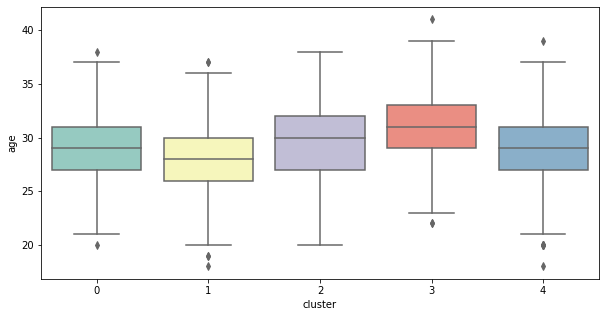

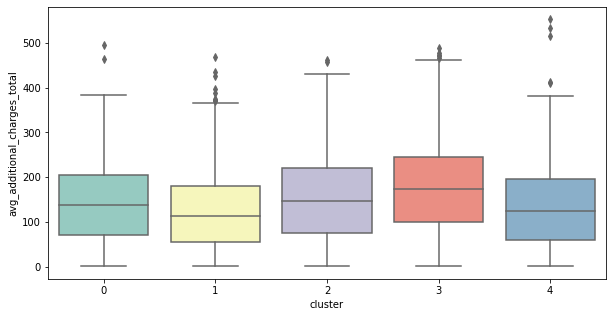

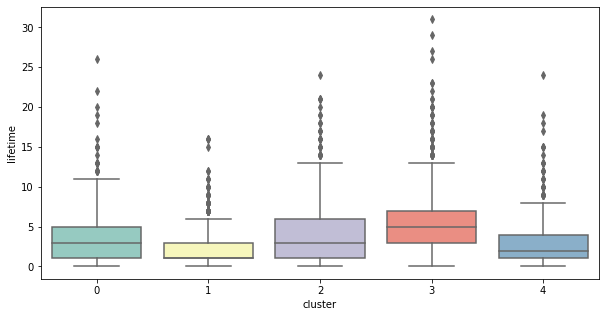

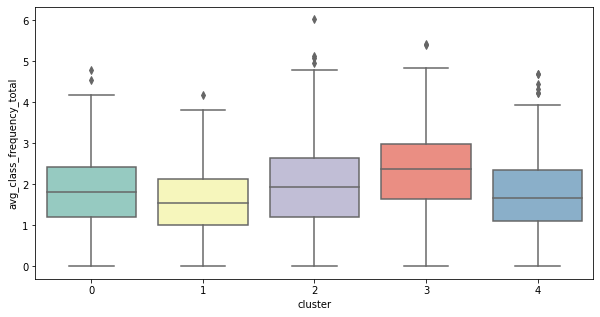

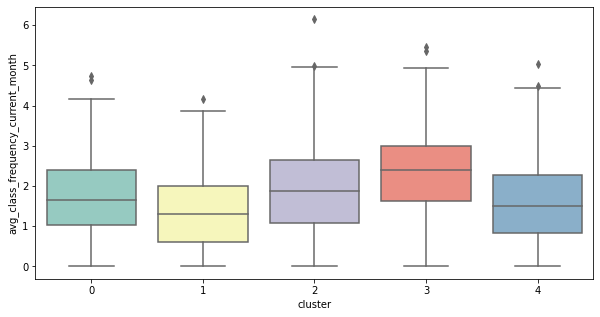

In [33]:
# построим графики для небинарных признаков
for column in [
    "month_to_end_contract",
    "age",
    "avg_additional_charges_total",
    "lifetime",
    "avg_class_frequency_total",
    "avg_class_frequency_current_month",
]:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x="cluster", y=df[column], data=df)
    plt.show()

* Самый длительный срок до окончания абонементов у 0 кластера-11 месяцев. Самый короткий у 1 кластера-около 5 месяцев    
* Для 0 и 3 кластера характерен среднй возраст около 30 лет   
* Самая большая сумма на доп услуги была потрачена 0 кластером  
* Самые высокие показатели лайфтами у 0 кластера   
* У 0 и 3 кластера чуть выше частота посещений,чем у остальных   

#### Для каждого полученного кластера посчитайте долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

In [34]:
# посмотрим средние значения оттока в кластерах
df.groupby("cluster").agg({"churn": "mean"}).sort_values(by="churn")

,churn
cluster,
3,0.012850
2,0.131737
0,0.266839
4,0.402154
1,0.492911


* Самый большой отток у 1 кластера 40%, на втором месте 2 кластер с 35%. Самые хорошие показатели у 0 кластера 13% и 3 кластера 20%  

### Выводы    

**В результате изучения данных**   

* В датафрейме 14 столбцов и 4000 строк.
* Пропусков и дубликатов нет.
* Название столбцов привели к нижнему регистру


**В результате исследовательского анализа данных**    

* На отток клиентов больше всего влияет лайфтайм,средняя частота посещений ,возраст и период контракт         
* В отток чаще уходят клиенты у которых абонемент на короткий срок, занимаются около месяца и дальше живут от клуба. Клиенты с парнерской программы и пришедшие по акции остаются чаще          
* Наиболее сильно коррелируют признаки Средняя частота посещений в неделю за все время с начала действия абонемента(Avg_class_frequency_total) со Средней частотой посещений в неделю за предыдущий месяц(Avg_class_frequency_current_month) и длительность текущего действующего абонемента(Contract_period) со сроком до окончания текущего действующего абонемента(Month_to_end_contract). Коэффициенты корреляции равны 0.95 и 0.97 соответственно.Эти признаки мультиколлинеарны   
* Признаки с практически нулевой корреляцией-пол и номер телефона  

**Выводы моделей прогнозирования оттоков клиентов**    

* Для прогнозирования оттоков клиента использовали модели логистической регрессии и случайного леса. Логистическая регрессия показала себя лучше по метрике Precision-доля прозноза относительно оттока клиентов 0.83 против 0.81
Остальные метрики у моделей совпали:  
* Метрика Accuracy-доля правильно угаданных ответов равна 90%              
* Метрика Recall показывает сколько реальных клиентов,находящихся в оттоке удалось обнаружить 0.80    
* Наиболее важными признаками влияющими на отток в обеих моделях оказались lifetime-время с момента первого обращения и средняя частота посещений в неделю.    
 
**В результате кластеризации**    

* Гендерное распределение для кластеров практически одинаковое    
* Расстояние от дома до фитнес центра: ближе всего клиенты из 2,3,4 кластера.Далеко от дома зал у клиентов из 0 кластера   
* Больше всего клиентов,пришедшие по партнерской программе из 0 кластера, а из тех кто ей не пльзовался-2,3 кластер     
* По акции Приведи друга пришли  900 клиентов из 0 кластера, и 1150 человек  не участвующих в этой программе.    
* Около 400 человек из 4 кластера не указали свой номер телефона.    
* Групповые занятия не посещают 1200 человек из 2 кластера ,а  800 человек из 3 кластера наоборот ходят постоянно
* Самый большой отток у 1 кластера 40%, на втором месте 2 кластер с 35%. Самые хорошие показатели у 0 кластера 13% и 3 кластера 20%  





## Основные выводы

* Самые хорошие показатели у 0 и 3 кластера, а значит это клиенты,которые живут рядом с клубом,пришли по партнерской программе или по акции Приведи друга.Они также любят посещать групповые занятия и имеют самый длительный абонемент. Чтобы увеличить лояльность этих кластеров необходимо уделить внимание качеству групповых тренировок, а также периодически предлагать всевозможные акции.   
* Больше всего отток у 1 и 2 кластера. Для 1 кластера можно предложить пользоваться услугами других клубов,которые будут ближе к их дому, а также предложить доп скидки для приобретения более длительных абонементов.Во 2 классе также стоить внимательно отнестись к качеству групповых тренировок и их расписанию, это еще и самая многочисленная группа 1235 человек из 4000